# Plant Disease Classification using Mobilenet

We use the PlantVillage dataset by Hughes et al. consists of about 87,000 healthy and unhealthy leaf images divided into 38 categories by species and disease. Here we provide a subset of our experiments on working with this data. We also end up transfer learning from MobileNet and use the weights from pre-training on ImageNet.

* ![PlantVillage Dataset Samples](https://i.imgur.com/Zcxdrlc.png)
Figure 1. PlantVillage Dataset Samples

## Classes

The following 38 classes are availaible in the dataset

- `Apple___Apple_scab` 
- `Apple___Black_rot` 
- `Apple___Cedar_apple_rust` 
- `Apple___healthy` 
- `Blueberry___healthy` 
- `Cherry_(including_sour)___Powdery_mildew` 
- `Cherry_(including_sour)___healthy` 
- `Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot` 
- `Corn_(maize)___Common_rust_` 
- `Corn_(maize)___Northern_Leaf_Blight` 
- `Corn_(maize)___healthy', 'Grape___Black_rot` 
- `Grape___Leaf_blight_(Isariopsis_Leaf_Spot)` 
- `Grape___healthy` 
- `Orange___Haunglongbing_(Citrus_greening)` 
- `Peach___Bacterial_spot` 
- `Peach___healthy` 
- `Pepper,_bell___Bacterial_spot` 
- `Pepper,_bell___healthy` 
- `Potato___Early_blight` 
- `Potato___Late_blight` 
- `Potato___healthy` 
- `Raspberry___healthy` 
- `Soybean___healthy` 
- `Squash___Powdery_mildew` 
- `Strawberry___Leaf_scorch` 
- `Strawberry___healthy` 
- `Tomato___Bacterial_spot` 
- `Tomato___Late_blight` 
- `Tomato___Leaf_Mold` 
- `Tomato___Septoria_leaf_spot` 
- `Tomato___Spider_mites Two-spotted_spider_mite` 
- `Tomato___Target_Spot` 
- `Tomato___Tomato_Yellow_Leaf_Curl_Virus` 
- `Tomato___Tomato_mosaic_virus` 
- `Tomato___healthy`

## References

[1] Hughes, David P., and Marcel Salathe. “An Open Access Repository of Images on Plant Health to Enable the Development of Mobile Disease Diagnostics.” ArXiv:1511.08060 [Cs], Apr. 2016. arXiv.org, http://arxiv.org/abs/1511.08060.

[2] Howard, Andrew G., et al. “MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications.” ArXiv:1704.04861 [Cs], Apr. 2017. arXiv.org, http://arxiv.org/abs/1704.04861.


## Setup

In [2]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
import torch 
import os

In [3]:
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)

batch_size = 32
epochs = 25


In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

In [4]:
base_dir = "../input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = os.path.join(base_dir,"train")
test_dir = os.path.join(base_dir,"valid")

In [5]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0,
                                                             shear_range = 0.2,
                                                             zoom_range = 0.2,
                                                             width_shift_range = 0.2,
                                                             height_shift_range = 0.2,
                                                             fill_mode="nearest")

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)

We will use `.flow_from_directory()` to generate batches of image data (and their labels) directly from our images in their respective folders.

In [6]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (image_size, image_size),
                                               batch_size = batch_size,
                                               class_mode = "categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = (image_size, image_size),
                                             batch_size = batch_size,
                                             class_mode = "categorical")

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [7]:
categories = list(train_data.class_indices.keys())
print(train_data.class_indices)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [8]:
import json
with open('class_indices.json','w') as f:
  json.dump(train_data.class_indices, f)

from IPython.display import FileLink
FileLink(r'class_indices.json')

/kaggle/working/class_indices.json

## Training

We first get the base MobileNet model without including the top layers since we want to use it for 38 classes and us the pre-trained weights for ImageNet.

In [9]:
base_model = tf.keras.applications.MobileNet(weights = "imagenet",
                                             include_top = False,
                                             input_shape = input_shape)

base_model.trainable = False

17227776/17225924 [==============================] - 0s 0us/step


In [10]:
inputs = keras.Input(shape = input_shape)

x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(categories), 
                          activation="softmax")(x)

model = keras.Model(inputs = inputs, 
                    outputs = x, 
                    name="LeafDisease_MobileNet")

In our multiple experiments we found out Adam optimizer to work really well with it's default learning rate, $\beta_1$, $\beta_2$ and $\epsilon$ values

In [11]:
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              metrics=[keras.metrics.CategoricalAccuracy(), 
                       'accuracy'])

In [12]:
history = model.fit(train_data,
                    validation_data=test_data,
                    epochs=epochs,
                    steps_per_epoch=150,
                    validation_steps=100)

Epoch 1/25
150/150 [==============================] - 91s 579ms/step - loss: 2.8783 - categorical_accuracy: 0.2731 - accuracy: 0.2731 - val_loss: 0.7801 - val_categorical_accuracy: 0.8100 - val_accuracy: 0.8100
Epoch 2/25
150/150 [==============================] - 84s 559ms/step - loss: 0.8413 - categorical_accuracy: 0.7645 - accuracy: 0.7645 - val_loss: 0.5293 - val_categorical_accuracy: 0.8525 - val_accuracy: 0.8525
Epoch 3/25
150/150 [==============================] - 82s 550ms/step - loss: 0.6038 - categorical_accuracy: 0.8283 - accuracy: 0.8283 - val_loss: 0.4226 - val_categorical_accuracy: 0.8784 - val_accuracy: 0.8784
Epoch 4/25
150/150 [==============================] - 81s 537ms/step - loss: 0.5009 - categorical_accuracy: 0.8478 - accuracy: 0.8478 - val_loss: 0.3407 - val_categorical_accuracy: 0.9034 - val_accuracy: 0.9034
Epoch 5/25
150/150 [==============================] - 79s 525ms/step - loss: 0.4027 - categorical_accuracy: 0.8854 - accuracy: 0.8854 - val_loss: 0.2900 - v

## Review the training process

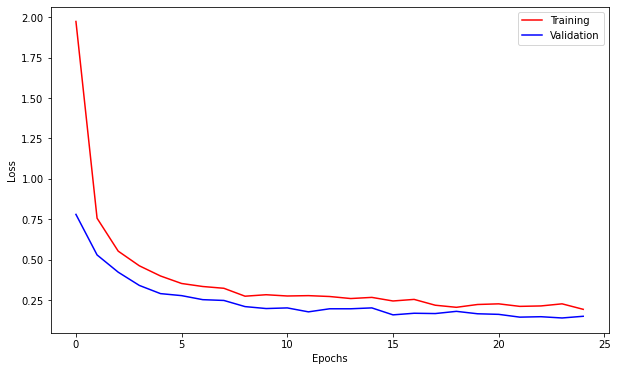

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

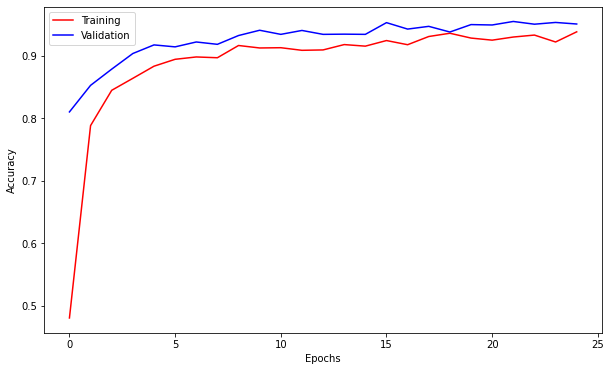

In [14]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

epochs = range(len(acc))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,acc,c="red",label="Training")
plt.plot(epochs,val_acc,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

## Save the model

We finally save the model in the standard TensorFlow 2 SavedModel format.

In [15]:
model.save('plant_disease')

In [ ]:
# saving the entire model to working directory
PATH = './plant-disease-model-complete.pth'
torch.save(model, PATH)